In [1]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten,Conv2D, MaxPool2D, MaxPooling2D, BatchNormalization, InputLayer, Activation, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import SGD, RMSprop, Adagrad

from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.mixed_precision import LossScaleOptimizer
from tensorflow.keras.metrics import Recall

import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import cv2
import random
import os
from random import shuffle
from tqdm import tqdm  
import scipy
import skimage
from skimage.transform import resize
import random

In [2]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [3]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [ ]:
data_dir = "/content/drive/My Drive/Malaria-Detection/Dataset1"

In [ ]:
model1 = Sequential()
model1.add(InputLayer(input_shape=(227,227,3),name ="Input"))
model1.add(Conv2D(96, 4 , activation='relu', padding= "valid", name ="Conv2d_1"))
model1.add(BatchNormalization(name="BatchNorm_1"))
model1.add(MaxPooling2D(pool_size=(3, 3), strides=(2,2), padding='valid', name = "MaxPool_1"))
model1.add(Conv2D(256, 1, padding ="same", activation='relu', name="Conv2d_2"))
model1.add(BatchNormalization(name="BatchNorm_2"))
model1.add(MaxPooling2D(pool_size=(3, 3), strides=(2,2), padding='valid', name="MaxPool_2"))
model1.add(Conv2D(384,1, padding ="same", activation='relu', name = "Conv2d_3"))
model1.add(Conv2D(384,1, padding ="same", activation='relu', name="Conv2d_4"))
model1.add(Conv2D(256, 4, activation='relu', padding= "valid", name="Conv2d_5"))
model1.add(BatchNormalization(name="BatchNorm_3"))
model1.add(MaxPooling2D(pool_size=(3, 3), strides=(2,2), padding='valid', name="MaxPool_3"))
model1.add(Flatten(name="Flatten_1"))
model1.add(Dense(409, activation='relu',name="Dense_1"))
model1.add(Dropout(0.25, name="Dropout_1"))
model1.add(Dense(409, activation='relu', name="Dense_2"))
model1.add(Dropout(0.25, name="Dropout_2"))
model1.add(Dense(409, 
                 activation='relu',
                 kernel_initializer='random_normal',
                 bias_initializer='zeros',
                 name="Dense_3"
                 ))
model1.add(Dropout(0.5, name = "Dropout_3"))
model1.add(Dense(2,
                 activation="softmax",
                 kernel_initializer='random_normal',
                 bias_initializer='zeros',
                 name="Dense_4"
                 ))




In [ ]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv2d_1 (Conv2D)           (None, 224, 224, 96)      4704      
                                                                 
 BatchNorm_1 (BatchNormaliza  (None, 224, 224, 96)     384       
 tion)                                                           
                                                                 
 MaxPool_1 (MaxPooling2D)    (None, 111, 111, 96)      0         
                                                                 
 Conv2d_2 (Conv2D)           (None, 111, 111, 256)     24832     
                                                                 
 BatchNorm_2 (BatchNormaliza  (None, 111, 111, 256)    1024      
 tion)                                                           
                                                                 
 MaxPool_2 (MaxPooling2D)    (None, 55, 55, 256)       0

In [ ]:
opt = SGD(learning_rate=0.001, momentum=0.52)
opt = LossScaleOptimizer(opt)


#https://www.kaggle.com/code/salokr/a-simple-cnn-knn-based-model-to-get-99-score/notebook


In [ ]:
lr_schedule = ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=1000,
    decay_rate=0.52)

opt1 = SGD(learning_rate=0.001,momentum=0.5, decay=0.5)
opt1 = LossScaleOptimizer(opt1)


In [ ]:
lr_schedule = ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=1000,
    decay_rate=0.5)
opt2 = RMSprop(
    learning_rate=0.001,
    rho=0.9,
    momentum=0.01,
    epsilon=1e-07,
    centered=True
)
opt2 = LossScaleOptimizer(opt2)


In [ ]:
opt3 = Adagrad(
    learning_rate=0.001,
    initial_accumulator_value=0.1,
    epsilon=1e-07,
    name="Adagrad",
)
opt3 = LossScaleOptimizer(opt3)


In [ ]:
model1.compile(
  loss= 'categorical_crossentropy',
  # optimizer= opt,
  # optimizer= opt1,
  # optimizer= opt2,
  optimizer= opt3,

  # metrics=[Recall()]
  metrics = ['accuracy']
)

In [4]:
# folders = glob('/Users/rutujajadhav/Desktop/r/Dataset/Train/*')
folders = glob('/content/drive/MyDrive/Malaria-Detection/Dataset1/Train/*')
folders

['/content/drive/MyDrive/Malaria-Detection/Dataset1/Train/Uninfected',
 '/content/drive/MyDrive/Malaria-Detection/Dataset1/Train/Parasite']

In [5]:
# PARA_DIR = "/Users/rutujajadhav/Desktop/r/Dataset/Train/Parasite/"
PARA_DIR = "/content/drive/MyDrive/Malaria-Detection/Dataset1/Train/Parasite/"
# UNIF_DIR =  "/Users/rutujajadhav/Desktop/r/Dataset/Train/Uninfected/"
UNIF_DIR = "/content/drive/MyDrive/Malaria-Detection/Dataset1/Train/Uninfected/"

In [6]:
Pimages = os.listdir(PARA_DIR)
Nimages = os.listdir(UNIF_DIR)

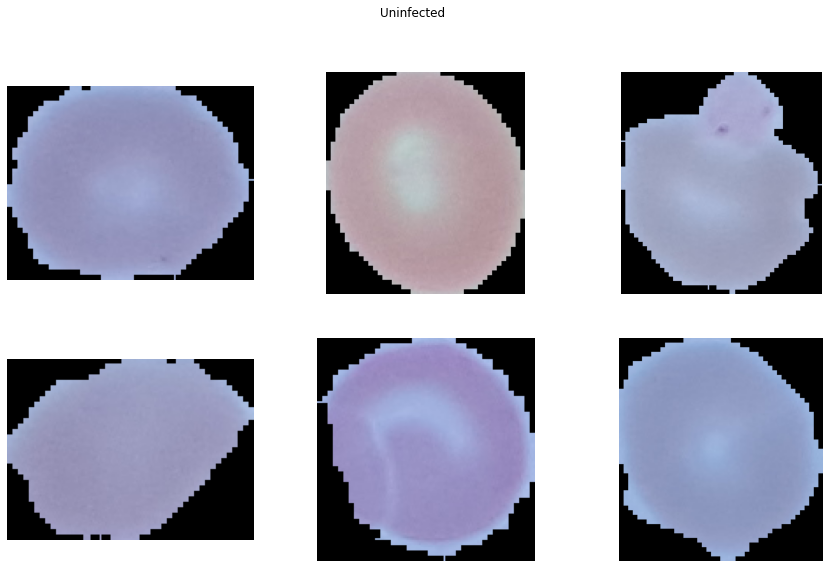

In [ ]:
sample_normal = random.sample(Nimages,6)
f,ax = plt.subplots(2,3,figsize=(15,9))

for i in range(0,6):
    # im = cv2.imread('/Users/rutujajadhav/Desktop/r/Dataset/Train/Uninfected/'+sample_normal[i])
    im = cv2.imread('/content/drive/MyDrive/Malaria-Detection/Dataset1/Train/Uninfected/'+sample_normal[i])
    ax[i//3,i%3].imshow(im)
    ax[i//3,i%3].axis('off')
f.suptitle('Uninfected')
plt.show()

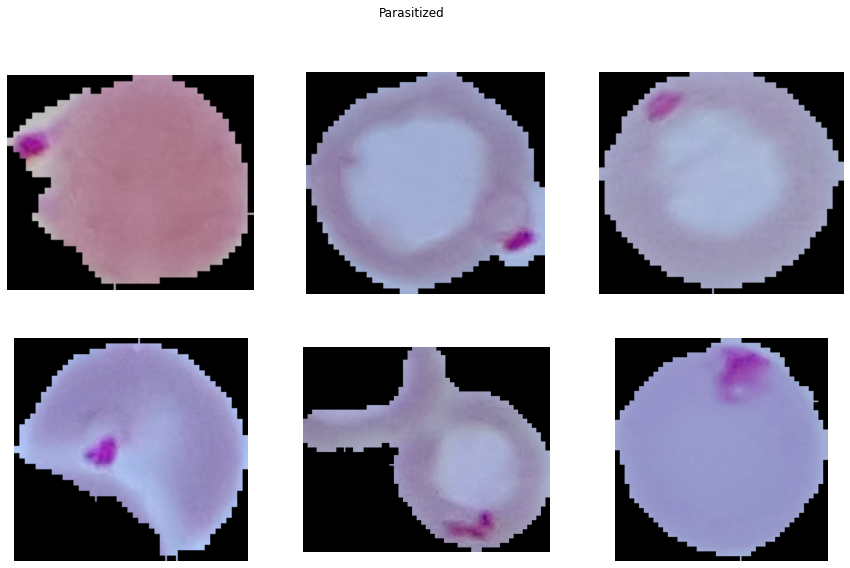

In [ ]:
sample_parasite = random.sample(Pimages,6)
f,ax = plt.subplots(2,3,figsize=(15,9))

for i in range(0,6):
    # im = cv2.imread('/Users/rutujajadhav/Desktop/r/Dataset/Train/Parasite/'+sample_parasite[i])
    im = cv2.imread('/content/drive/MyDrive/Malaria-Detection/Dataset1/Train/Parasite/'+sample_parasite[i])
    ax[i//3,i%3].imshow(im)
    ax[i//3,i%3].axis('off')
f.suptitle('Parasitized')
plt.show()

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                  validation_split=0.2) # set validation split

test_datagen = ImageDataGenerator(rescale = 1./255)

In [82]:
training_set_all = train_datagen.flow_from_directory('/content/drive/MyDrive/Malaria-Detection/Dataset1/Train/',
                                                 target_size = (227, 227),
                                                 batch_size = 20,
                                                 class_mode = 'categorical')

Found 416 images belonging to 2 classes.


In [8]:
training_set = train_datagen.flow_from_directory('/content/drive/MyDrive/Malaria-Detection/Dataset1/Train/',
                                                 target_size = (227, 227),
                                                 batch_size = 20,
                                                 class_mode = 'categorical',
                                                     subset='training') # set as training data

Found 333 images belonging to 2 classes.


In [9]:
validation_data = train_datagen.flow_from_directory('/content/drive/MyDrive/Malaria-Detection/Dataset1/Train/',
                                                 target_size = (227, 227),
                                                 batch_size = 20,
                                                 class_mode = 'categorical',
                                                     subset='validation') # set as validation data

Found 83 images belonging to 2 classes.


In [10]:
test_set1 = test_datagen.flow_from_directory('/content/drive/MyDrive/Malaria-Detection/Dataset1/Test/',
                                            target_size = (227, 227),
                                            batch_size = 20,
                                            class_mode = 'categorical')

Found 134 images belonging to 2 classes.


In [11]:
print('Training Data : '+str(training_set.__len__()))
print('Validation Data : '+str(validation_data.__len__()))

print('Test Data : '+str(test_set1.__len__()))


Training Data : 17
Validation Data : 5
Test Data : 7


In [ ]:
from tensorflow.keras.models import load_model

r1 = model1.fit(
  training_set,
  validation_data= validation_data,
  epochs=40,
  batch_size = 20,
  # steps_per_epoch=len(training_set),
  # validation_steps=len(validation_data),
  workers=20
)

# model1.save('/content/drive/MyDrive/Malaria-Detection/model3_CNN.h5')

# import pickle
# pickle.dump(model1, open('/content/drive/MyDrive/Malaria-Detection/model3_CNN.pkl', 'wb'))

Epoch 1/40
17/17 [==============================] - 15s 712ms/step - loss: 0.3783 - accuracy: 0.8438 - val_loss: 0.9677 - val_accuracy: 0.4699
Epoch 2/40
17/17 [==============================] - 15s 722ms/step - loss: 0.3983 - accuracy: 0.8138 - val_loss: 1.0004 - val_accuracy: 0.4699
Epoch 3/40
17/17 [==============================] - 15s 707ms/step - loss: 0.2934 - accuracy: 0.8679 - val_loss: 0.9793 - val_accuracy: 0.4699
Epoch 4/40
17/17 [==============================] - 14s 706ms/step - loss: 0.3152 - accuracy: 0.8619 - val_loss: 1.0550 - val_accuracy: 0.4699
Epoch 5/40
17/17 [==============================] - 15s 718ms/step - loss: 0.2564 - accuracy: 0.8829 - val_loss: 0.9783 - val_accuracy: 0.4699
Epoch 6/40
17/17 [==============================] - 15s 715ms/step - loss: 0.2207 - accuracy: 0.9099 - val_loss: 0.9555 - val_accuracy: 0.4699
Epoch 7/40
17/17 [==============================] - 15s 713ms/step - loss: 0.2108 - accuracy: 0.9129 - val_loss: 1.1214 - val_accuracy: 0.4699

In [ ]:

model1.save('/content/drive/MyDrive/Malaria-Detection/model3_op3_CNN.h5')

import pickle
pickle.dump(model1, open('/content/drive/MyDrive/Malaria-Detection/model3_op3_CNN.pkl', 'wb'))

INFO:tensorflow:Assets written to: ram://5c8cde7b-e8d1-4f92-905d-71336f06b9b9/assets


INFO:tensorflow:Assets written to: ram://5c8cde7b-e8d1-4f92-905d-71336f06b9b9/assets


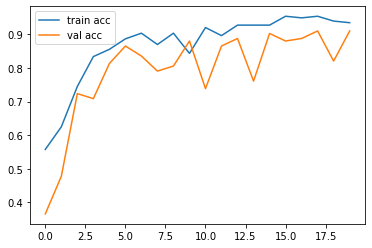

In [ ]:
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

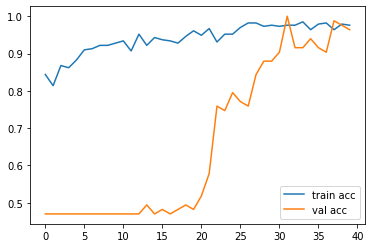

In [ ]:
plt.plot(r1.history['accuracy'], label='train acc')
plt.plot(r1.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

In [ ]:
from tensorflow.keras.models import load_model

model.save('model2_vgg19.h5')

In [ ]:
print('Training Data : '+str(training_set.__len__()))
print('Test Data : '+str(test_set1.__len__()))


Training Data : 17
Test Data : 7


In [61]:
from tensorflow.keras.models import load_model
classifier =load_model('/content/drive/MyDrive/Malaria-Detection/model2_CNN.h5')

In [27]:
# visualize confusion matrix on heat map
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def print_cmx(y_true, y_pred):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)

    plt.figure(figsize = (10,7))
    sn.heatmap(df_cmx, annot=True)
    plt.show()


In [62]:
from tensorflow.keras.models import Model
new_model=Model(inputs=classifier.input,outputs=classifier.get_layer('Dropout_2').output)
#Let's obtain the Input Representations
train_set=new_model.predict(training_set)
test_set=new_model.predict(test_set1)
#Convert back the labels
#We are now going to have a single row for each example
# TO CHANGE
# train_set=train_set.reshape(42000,5*5*64)
# test_set=test_set.reshape(28000,5*5*64)

In [63]:
print(train_set.shape)
print(test_set.shape)

(333, 409)
(134, 409)


In [84]:
x_train_all=np.concatenate([training_set_all.next()[0] for i in range(training_set_all.__len__())])
y_train_all=np.concatenate([training_set_all.next()[1] for i in range(training_set_all.__len__())])

In [72]:
x_train=np.concatenate([training_set.next()[0] for i in range(training_set.__len__())])
y_train=np.concatenate([training_set.next()[1] for i in range(training_set.__len__())])

In [73]:
x_train_2=np.concatenate([validation_data.next()[0] for i in range(validation_data.__len__())])
y_train_2=np.concatenate([validation_data.next()[1] for i in range(validation_data.__len__())])

In [74]:
x_test=np.concatenate([test_set1.next()[0] for i in range(test_set1.__len__())])
y_test=np.concatenate([test_set1.next()[1] for i in range(test_set1.__len__())])

In [85]:
x_train_all_features = new_model.predict(x_train_all)
x_train_features = new_model.predict(x_train)
x_train_2_features = new_model.predict(x_train_2)
x_test_features = new_model.predict(x_test)


In [138]:
print(y_test)

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 

In [147]:
for i in test_set1.filenames:
    print(i)

Parasite/C39P4thinF_original_IMG_20150622_105554_cell_10.png
Parasite/C39P4thinF_original_IMG_20150622_105554_cell_11.png
Parasite/C39P4thinF_original_IMG_20150622_105554_cell_12.png
Parasite/C39P4thinF_original_IMG_20150622_105554_cell_13.png
Parasite/C39P4thinF_original_IMG_20150622_105554_cell_14.png
Parasite/C39P4thinF_original_IMG_20150622_105554_cell_15.png
Parasite/C39P4thinF_original_IMG_20150622_105554_cell_16.png
Parasite/C39P4thinF_original_IMG_20150622_105554_cell_17.png
Parasite/C39P4thinF_original_IMG_20150622_105554_cell_18.png
Parasite/C39P4thinF_original_IMG_20150622_105554_cell_19.png
Parasite/C39P4thinF_original_IMG_20150622_105554_cell_20.png
Parasite/C39P4thinF_original_IMG_20150622_105554_cell_21.png
Parasite/C39P4thinF_original_IMG_20150622_105554_cell_22.png
Parasite/C39P4thinF_original_IMG_20150622_105554_cell_23.png
Parasite/C39P4thinF_original_IMG_20150622_105554_cell_24.png
Parasite/C39P4thinF_original_IMG_20150622_105554_cell_25.png
Parasite/C39P4thinF_orig

In [86]:
y_train_all_flat = np.argmax(y_train_all, axis=1)
y_train_flat = np.argmax(y_train, axis=1)
y_train_2_flat = np.argmax(y_train_2, axis=1)
y_test_flat = np.argmax(y_test, axis=1)

In [139]:
print(y_test_flat)

[0 0 0 1 0 0 1 0 0 1 1 0 1 1 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 1 1 1 1 0 1 1 0 0 1 0 0 1 0 0 1 1 0 0 0 1 0 0 1 0 1 0 1 1 1 0 1 0
 0 0 0 0 1 0 0 1 0 0 0 0 1 1 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 1 0 0 1 1 0 0
 1 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 1]


In [88]:
print(x_train_all_features.shape ,x_train_features.shape, x_train_2_features.shape, x_test_features.shape)
print(y_train_all_flat.shape, y_train_flat.shape, y_train_2_flat.shape, y_test_flat.shape)

(416, 409) (333, 409) (83, 409) (134, 409)
(416,) (333,) (83,) (134,)


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

parameters = {"n_neighbors": [1, 5, 10, 30, 32, 64, 86],
              "weights": ['uniform'],
              "metric": ['minkowski'],
              "leaf_size":[1,3, 10, 20],
              "algorithm": ['auto', 'ball_tree', 'kd_tree', 'brute'],
              "p":[1,2,10,15,20]
              }
kclf = KNeighborsClassifier()
kgclf = GridSearchCV(kclf, param_grid=parameters, cv=10, scoring='accuracy', return_train_score=False,verbose=1, refit=True)

kgclf.fit(x_train_all_features, y_train_all)

Fitting 10 folds for each of 560 candidates, totalling 5600 fits


In [203]:
kclf = kgclf.best_estimator_
kclf.fit(x_train_all_features, y_train_all)

KNeighborsClassifier(leaf_size=1, n_neighbors=10, p=1, weights='distance')

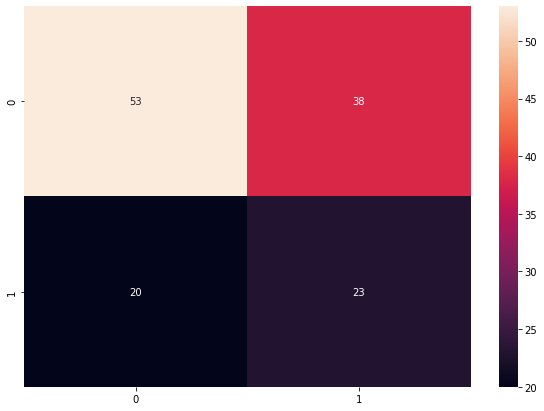

              precision    recall  f1-score   support

           0       0.73      0.58      0.65        91
           1       0.38      0.53      0.44        43

    accuracy                           0.57       134
   macro avg       0.55      0.56      0.54       134
weighted avg       0.61      0.57      0.58       134

Accuracy: 0.5671641791044776


In [205]:

y_test_KNN = kclf.predict(x_test_features)
y_test_KNNflat = np.argmax(y_test_KNN, axis=1)


from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
print_cmx(y_test_flat.T, y_test_KNNflat)
print(classification_report(y_test_flat, y_test_KNNflat))
print("Accuracy: {0}".format(accuracy_score(y_test_flat, y_test_KNNflat)))


In [ ]:
y_pred = model.predict(test_set)

In [ ]:
y_pred

array([[9.9819463e-01, 1.8054114e-03],
       [9.9945599e-01, 5.4407300e-04],
       [9.9471539e-01, 5.2845511e-03],
       [5.5716217e-01, 4.4283780e-01],
       [1.7551520e-01, 8.2448477e-01],
       [1.8165258e-01, 8.1834745e-01],
       [2.5615332e-01, 7.4384671e-01],
       [4.9283889e-01, 5.0716102e-01],
       [2.9270124e-01, 7.0729876e-01],
       [4.6315503e-01, 5.3684497e-01],
       [9.9640012e-01, 3.5998535e-03],
       [1.5682185e-01, 8.4317815e-01],
       [2.6788801e-01, 7.3211199e-01],
       [8.3348185e-01, 1.6651815e-01],
       [9.0849304e-01, 9.1506958e-02],
       [9.9952936e-01, 4.7067297e-04],
       [9.4206548e-01, 5.7934463e-02],
       [9.2250752e-01, 7.7492490e-02],
       [9.9807358e-01, 1.9263531e-03],
       [9.0530747e-01, 9.4692580e-02],
       [9.9999511e-01, 4.8848628e-06],
       [7.7909660e-01, 2.2090338e-01],
       [9.5817727e-01, 4.1822754e-02],
       [4.7147498e-01, 5.2852499e-01],
       [6.4079052e-01, 3.5920948e-01],
       [4.2662790e-01, 5.

In [ ]:
import numpy as np
y_pred = np.argmax(y_pred, axis=1)

In [ ]:
y_pred

array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0,
       0, 1])

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

In [ ]:
model=load_model('model2_vgg19.h5')

In [185]:
# img=image.load_img('/Users/rutujajadhav/Desktop/r/Dataset/Test/Uninfected/2.png',target_size=(224,224))
# img=image.load_img('/content/drive/MyDrive/Malaria-Detection/TestImages/2.png',target_size=(227,227))
# img=image.load_img('/content/drive/MyDrive/Malaria-Detection/TestImages/C99P60ThinF_IMG_20150918_142128_cell_110.png',target_size=(227,227))
img=image.load_img('/content/drive/MyDrive/Malaria-Detection/TestImages/C39P4thinF_original_IMG_20150622_105335_cell_15.png',target_size=(227,227))



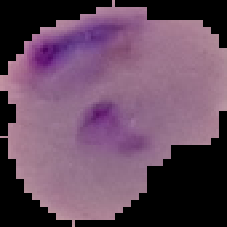

In [186]:
img

In [187]:
x=image.img_to_array(img)
x

array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]], dtype=float32)

In [188]:
x.shape

(227, 227, 3)

In [189]:
x=x/255
x.shape


(227, 227, 3)

In [190]:
x=np.expand_dims(x,axis=0)
img_data=preprocess_input(x)
# img_data = x.reshape(1,227,227,3)

img_data.shape

(1, 227, 227, 3)

In [191]:
# model.predict(x)
features = new_model.predict(x)
value = kclf.predict(features)
print(value)
a= np.argmax(value, axis=1)

[[0. 1.]]


In [192]:
a=np.argmax(model.predict(x), axis=1)

NameError: ignored

In [193]:
if(a==1):
    print("Uninfected")
else:
    print("Infected")
  

Uninfected
